# Convolutional Neural Network - MNIST

In this notebook, my goal is to implement a CNN to classify handwritten digits from the MNIST dataset using PyTorch. 

Classifying handwritten digits is not new to me at this point 😅. In the previous folder, I used PyTorch to implement an MLP to do the very same thing, and acheived 96% accuracy on the testing set, which I think is pretty good! 🤷

So, implementing this is CNN is also a chance for me to compare the performance of two different architectures (CNN and MLP) on the very same task. In `README.md` of this folder, I introduced CNNs as a family of models that are *well-suited for image-related task*. By the end of this notebook, I will see for myself! The score to beat is: 96%

Okay, let's jump right in!

# Model Overview

The architecture of the network that I am going to implement is shown on the following image:

![Deep CNN architecture](./images/img-7.jpg)

It is not new to me that training examples are usually fed to networks in batches. So, I would like to describe the journey of a batch throughout the network. For simplicity, I choose 3 as the batchsize, and assume the image is black and white (i.e. one color channel) and of size $(28 \times 28)$.

$\longrightarrow$ When the batch of 3 images gets fed in the network, through the input layer, **EACH** image in the batch gets convolved with 32 different filters (of size $5 \times 5$). Convolving **EACH** image in batch with 32 kernels results in **32** features maps for **EACH** image. Another way to see this is that after an image in the batch gets convolved the 32 filters, the result is a $(28 \times 28 \times 32)$ matrix... 32 channels (i.e. features maps). So, after all three images in the batch go through this layer, the result is a 4-D matrix containing THREE $(28 \times 28 \times 32)$ matrices. If you do not understand this, consider reading the section of `cnn-basics.ipynb` where I talk about convolving on 3-D matrices.

Still with me? Cool! Let's proceed.

$\longrightarrow$ The three sets of 32 feature maps we got out of the convolutional layer (in the form of a 4-D matrix containing THREE $(28 \times 28 \times 32)$ matrices) get fed in a subsampling layer where a max-pooling operation, $P_{2 \times 2}$, takes place. As I learned in `cnn-basics.ipynb`, pooling decreases the resolution of feature maps. So, the 32 feature maps of **EACH** image get downsized from $(28 \times 28)$ to $(14 \times 14)$. After the batch goes through the subsampling layer, the result is still a 4-D matrix containing THREE smaller $(14 \times 14 \times 32)$ feature maps matrices.

$\longrightarrow$ The batch of feature map matrices now gets fed into another convolutional layer. Each feature map matrix gets convolved with 64 kernels. Remember in `cnn-basics.ipynb`, I said the following when talking about performing convolutions:

>  The filters must have the SAME number of channels as the input image

Here, we are feeding 3 feature map matrices (32 channels each) in the conv. layer. So, each of the 64 filters must also have 32 channels. After convolving the 64 filters (of size $5 \times 5$) with each feature map matrix, the result is a batch of 3 new feature map matrices of 64 channels each.

Are still there?! Hang on, almost done. I need to understand it. Articulating helps!

$\longrightarrow$ Next is another pooling layer. The batch containing our THREE $(14 \times 14 \times 64)$ matrices get fedin a sampling layer where a max-pooling operation, $P_{2 \times 2}$, takes place. The result our batch with three smaller $(7 \times 7 \times 64)$ feature maps matrices.

$\longrightarrow$ Each feature map matrix in the batch is flatten, then fed in to MLP basically, and the rest I familiar already :)

Here is the list of layers I described, and the tensor size to feed them:

- `Input`: [batchsize $\times 28 \times 28 \times 1 $]

- `Conv_1`: [batchsize $\times 28 \times 28 \times 32 $]

- `Pooling_1`: [batchsize $\times 14 \times 14 \times 32 $]

- `Conv_2`: [batchsize $\times 14 \times 14 \times 64 $]

- `Pooling_2`: [batchsize $\times 28 \times 28 \times 1 $]

- `FC_1`: [batchsize $\times 1024$]

- `FC_2` and `softmax` layer: [batchsize $\times 10$]

Remember, in `cnn-basics.ipynb`, I said this:

> Colored images are often represented by 3-D matrices. Different Deep Learning frameworks will follow **different conventions**, but I know for sure that one dimension represents the width of the image, another represents the height of the image, and the remaining one represents the number of color channel in the image.

The key term is: **convention**.

Above, I followed my own convention to help my understanding. 🤷

But, when we read an image, the default dimension for the channels is the first dimension of the tensor array (if we add a batch dimension). This is called the **`NCHW` format**, where `N` stands for the number of images within the batch, `C` stands for channels, and `H` and `W` stand for height and width, respectively.

In PyTorch, `Conv2D`, the convolutional class, assumes that inputs are in the `NCHW` format by default. TensorFlow, on the other hand, uses use NHWC format. Moving forward, I will follow the `NCHW` format.

# Loading and Preprocessing the data

As I said earlier, this CNN is to classify handwritten digits from the MNIST dataset. So let's go ahead and load the dataset using `torchvision` module.

The MNIST dataset come with pre-specified **training** and **testing** partitions. Before, I used the **training** partition to train, and the **testing** partition to test. This time however, I use a portion of the training partition for validation.

In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Subset

image_path = './dataset'
transform = transforms.Compose([
    transforms.ToTensor()
])

#Download the training partition of the MNIST dataset 
mnist_dataset = torchvision.datasets.MNIST(
    root=image_path, train=True,
    transform=transform, download=True
)

#Split the training partition in two. and use one portion 
#for validation 
mnist_valid_dataset = Subset(
    mnist_dataset,
    torch.arange(10000) #Use the [0, 10000) examples for validation
)

mnist_train_dataset = Subset(
    mnist_dataset,
    torch.arange(10000, len(mnist_dataset)) #Use [10000, data size) for training
)

#Download the test part of the dataset
mnist_test_dataset = torchvision.datasets.MNIST(
    root=image_path, train=False,
    transform=transform, download=False
)

Let's create some `DataLoader` instances to help us iterate on our dataset in batches.

In [2]:
from torch.utils.data import DataLoader

batch_size = 64
torch.manual_seed(1)

train_dl = DataLoader(mnist_train_dataset,
                      batch_size,
                      shuffle=True)

valid_dl = DataLoader(mnist_valid_dataset,
                      batch_size,
                      shuffle=False)

I am now ready to implement the CNN architecture described earlier. Let's do this.

# Implementing the model using PyTorch

As before, I am going to use PyTorch's `nn.module`.

In [3]:
import torch.nn as nn

model = nn.Sequential()

Let's add the first convolutional layer to the model followed by the activation function `RELU`

In [4]:
model.add_module(
    'conv1',
    nn.Conv2d(
        in_channels=1, out_channels=32,
        kernel_size=5, padding=2
    )
)

model.add_module(
    'relu1',
    nn.ReLU()
)

I mentioned the term `Conv2d` before. But had never used it in practice. Now, it's my first time using it. Let's describe each paramater in the `Conv2d` constructor. This class is the PyTorch class that performs 2D convolution over an input signal composed of several input planes (i.e channels).

`in_channel` $\to$ the number of channels (i.e planes) training examples, input to this conv. layer, should have.

`out_channel` $\to$ the number of channels produced by the convolution.

`kernel_size` $\to$ the size of the filters. These are square matrices.

`padding` $\to$ padding around the input.

In plain english, I am creating a 2D convolution layer that accepts inputs with `1` channel (`in_channel`), and outputs matrices with `32` channels (`out_channels`). The fact that this convolutional layer outputs matrices of `32` channels suggests that the inputs of this layer are convolved with `32` filters. Each of size $5 \times 5$ (`kernel_size`). But remember, the filters must have the *SAME* number of channels as the input. So, each of the `32` filter are of size $(1 \times 5 \times 5)$, where 1 is the number of channels.

Let's add the first max-pooling layer to the model

In [5]:
model.add_module(
    'pool1',
    nn.MaxPool2d(kernel_size=2)
)

Now, I am going to add the second convolutional layer to the model and also follow it by a `RELU` activation. 

In [6]:
model.add_module(
    'conv2',
    nn.Conv2d(
        in_channels=32, out_channels=64,
        kernel_size=5, padding=2
    )
)

model.add_module(
    'relu2',
    nn.ReLU()
)

Here, we created a 2D convolutional layer that accepts inputs with `32` channels, and outputs matrices with `64` channels. It suggests that inputs to this layers are convolved with `64` different filters. And since filters should have the same number of channels as the input, each of the 64 filters in this layer is of size $(32 \times 5 \times 5)$ where 32 is the number of channels. 

Let's continue and add the second max-pooling layer to the model.

In [7]:
model.add_module(
    'pool2',
    nn.MaxPool2d(kernel_size=2)
)

Good! I am done with the convolutions and stuff. At this stage, training examples coming out of the `pool2` layer should be of the form: $[N \times 64 \times 7 \times 7]$, where `N` is the batch size, `64` is the number of channels in each output matrices,  and the two last `7`s are the height and the width of the feature maps respectively.

Now, I will flatten the output of the `pool2` layer, and feed it into the fully connected portion of our architecture. This is basically the MLP section of the network.

In [8]:
model.add_module('flatten',nn.Flatten())
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(1024, 10))

`fc2`, last fully connected layer, has 10 output units for the 10 class labels in the MNIST dataset. In practice, we usually use the softmax activation to obtain the class-membership probabilities of each input example. But since the softmax function is already used internally inside PyTorch's `CrossEntropyLoss` loss function implementation, I do not explicitely add it as a layer.

Speaking of the loss function, let's add it to our model:

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

That's it! We successfully implemented the CNN architecture above using PyTorch. We can print out the model, and get a list of the layers we added:

In [10]:
model

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

# Training the model

I would like to train my model on the GPU. But let's see if the CUDA is accessible to us

In [11]:
#Move model to GPU here.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Now, let's move the model to the GPU

In [12]:
model = model.to(device)

Below, I defining the `train` function to train the model we defined earlier. This function switch the model between "training" mode and "evaluation" mode using the `model.train()` and `model.eval()` respectively. This function is not short, but I leave extensive comments to help future me.

In [13]:
def train(model, num_epochs, train_dl, valid_dl):
    #loss and accuracy PER epoch during training
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs

    #loss and accuracy PER epoch during validation
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        
        #Switch model in training mode 
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            #1-forward pass, then compute loss
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)

            #2-compute gradients through backpropagation 
            # and update weights
            loss.backward()
            optimizer.step()

            #3-zero out gradients, so they don't accumulate
            optimizer.zero_grad()

            #4-Compute running loss. 
            # NOTE: loss.item() contains the loss of the entire 
            # batch divided by the batch size.  
            # Multiplying the average batch loss with 
            #the number of training example = the total loss for this batch
            #The line below accumulates the total loss per batch for 
            #the ENTIRE epoch.
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)

            #4-accumulates the number of correct predictions
            # per batch for the ENTIRE epoch
            is_correct = (
                torch.argmax(pred, dim=1) == y_batch
            ).float()
            accuracy_hist_train[epoch] += is_correct.sum().item()
        
        #5-Compute average and accuracy loss of this epoch
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        #Switch model in evaluation mode
        model.eval()

        with torch.no_grad(): #disable gradient calculation
            for x_batch, y_batch in valid_dl:       
                x_batch, y_batch = x_batch.to(device), y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)   
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (
                    torch.argmax(pred, dim=1) == y_batch
                ).float()
                accuracy_hist_valid[epoch] += is_correct.sum().item()
        
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        #
        print(f'Epoch {epoch + 1}: training accuracy: '
              f'{accuracy_hist_train[epoch]:.4f} validation accuracy: '
              f'{accuracy_hist_valid[epoch]:.4f}')
        
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

With the `train` routine written, let's use it to train `model`

In [14]:
torch.manual_seed(1)

num_epochs = 20
history = train(model, num_epochs=num_epochs, train_dl=train_dl, valid_dl=valid_dl)

Epoch 1: training accuracy: 0.9501 validation accuracy: 0.9831
Epoch 2: training accuracy: 0.9848 validation accuracy: 0.9825
Epoch 3: training accuracy: 0.9893 validation accuracy: 0.9831
Epoch 4: training accuracy: 0.9917 validation accuracy: 0.9884
Epoch 5: training accuracy: 0.9933 validation accuracy: 0.9910
Epoch 6: training accuracy: 0.9940 validation accuracy: 0.9901
Epoch 7: training accuracy: 0.9949 validation accuracy: 0.9915
Epoch 8: training accuracy: 0.9964 validation accuracy: 0.9911
Epoch 9: training accuracy: 0.9961 validation accuracy: 0.9911
Epoch 10: training accuracy: 0.9966 validation accuracy: 0.9904
Epoch 11: training accuracy: 0.9971 validation accuracy: 0.9894
Epoch 12: training accuracy: 0.9978 validation accuracy: 0.9903
Epoch 13: training accuracy: 0.9971 validation accuracy: 0.9913
Epoch 14: training accuracy: 0.9983 validation accuracy: 0.9896
Epoch 15: training accuracy: 0.9979 validation accuracy: 0.9911
Epoch 16: training accuracy: 0.9984 validation ac

Hum... the results looks very good! The CNN architecture we implemented performed better than the MLP. As a recall, the MLP acheived a 96% accuracy on testing set. From the above, the CNN acheives 99% accuracy. This is very encouraging. Let's visualize the learning curves of the model

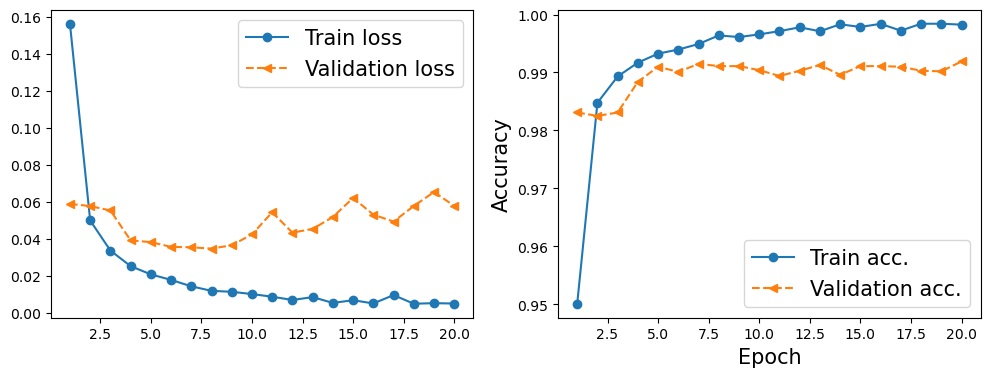

In [15]:
import matplotlib.pyplot as plt
import numpy as np

x_arr = np.arange(len(history[0])) + 1 #the number of epochs
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, history[0], '-o', label='Train loss')
ax.plot(x_arr, history[1], '--<', label='Validation loss')
ax.legend(fontsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, history[2], '-o', label='Train acc.')
ax.plot(x_arr, history[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)

ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

The visuals are cool, but let's not get ahead of ourselves just yet. I would like to test the CNN on the testing dataset. It is data, it has never seen. So, if it performs better there, I will be very proud.

# Last words...